# Seasonal-Trend decomposition using LOESS (STL)

This note book illustrates the use of `STL` to decompose a time series into three components: trend, season(al) and residual. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components.  The key inputs into `STL` are:

* `season` - The length of the seasonal smoother. Must be odd.
* `trend` - The length of the trend smoother, usually around 150% of `season`.  Must be odd and larger than `season`.
* `low_pass` - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.

First we import the required packages, prepare the graphics environment, and prepare the data. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style('darkgrid')

In [2]:
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)

## Atmospheric CO2

The example in Cleveland, Cleveland, McRae, and Terpenning (1990) uses CO2 data, which is in the list below.  This monthly data (January 1959 to December 1987) has a clear trend and seasonality across the sample. 

In [3]:
co2 = [315.58, 316.39, 316.79, 317.82, 318.39, 318.22, 316.68, 315.01, 314.02, 313.55, 
       315.02, 315.75, 316.52, 317.10, 317.79, 319.22, 320.08, 319.70, 318.27, 315.99, 
       314.24, 314.05, 315.05, 316.23, 316.92, 317.76, 318.54, 319.49, 320.64, 319.85, 
       318.70, 316.96, 315.17, 315.47, 316.19, 317.17, 318.12, 318.72, 319.79, 320.68, 
       321.28, 320.89, 319.79, 317.56, 316.46, 315.59, 316.85, 317.87, 318.87, 319.25, 
       320.13, 321.49, 322.34, 321.62, 319.85, 317.87, 316.36, 316.24, 317.13, 318.46, 
       319.57, 320.23, 320.89, 321.54, 322.20, 321.90, 320.42, 318.60, 316.73, 317.15, 
       317.94, 318.91, 319.73, 320.78, 321.23, 322.49, 322.59, 322.35, 321.61, 319.24, 
       318.23, 317.76, 319.36, 319.50, 320.35, 321.40, 322.22, 323.45, 323.80, 323.50, 
       322.16, 320.09, 318.26, 317.66, 319.47, 320.70, 322.06, 322.23, 322.78, 324.10, 
       324.63, 323.79, 322.34, 320.73, 319.00, 318.99, 320.41, 321.68, 322.30, 322.89, 
       323.59, 324.65, 325.30, 325.15, 323.88, 321.80, 319.99, 319.86, 320.88, 322.36, 
       323.59, 324.23, 325.34, 326.33, 327.03, 326.24, 325.39, 323.16, 321.87, 321.31, 
       322.34, 323.74, 324.61, 325.58, 326.55, 327.81, 327.82, 327.53, 326.29, 324.66, 
       323.12, 323.09, 324.01, 325.10, 326.12, 326.62, 327.16, 327.94, 329.15, 328.79, 
       327.53, 325.65, 323.60, 323.78, 325.13, 326.26, 326.93, 327.84, 327.96, 329.93, 
       330.25, 329.24, 328.13, 326.42, 324.97, 325.29, 326.56, 327.73, 328.73, 329.70, 
       330.46, 331.70, 332.66, 332.22, 331.02, 329.39, 327.58, 327.27, 328.30, 328.81, 
       329.44, 330.89, 331.62, 332.85, 333.29, 332.44, 331.35, 329.58, 327.58, 327.55, 
       328.56, 329.73, 330.45, 330.98, 331.63, 332.88, 333.63, 333.53, 331.90, 330.08, 
       328.59, 328.31, 329.44, 330.64, 331.62, 332.45, 333.36, 334.46, 334.84, 334.29, 
       333.04, 330.88, 329.23, 328.83, 330.18, 331.50, 332.80, 333.22, 334.54, 335.82, 
       336.45, 335.97, 334.65, 332.40, 331.28, 330.73, 332.05, 333.54, 334.65, 335.06, 
       336.32, 337.39, 337.66, 337.56, 336.24, 334.39, 332.43, 332.22, 333.61, 334.78, 
       335.88, 336.43, 337.61, 338.53, 339.06, 338.92, 337.39, 335.72, 333.64, 333.65, 
       335.07, 336.53, 337.82, 338.19, 339.89, 340.56, 341.22, 340.92, 339.26, 337.27, 
       335.66, 335.54, 336.71, 337.79, 338.79, 340.06, 340.93, 342.02, 342.65, 341.80, 
       340.01, 337.94, 336.17, 336.28, 337.76, 339.05, 340.18, 341.04, 342.16, 343.01, 
       343.64, 342.91, 341.72, 339.52, 337.75, 337.68, 339.14, 340.37, 341.32, 342.45, 
       343.05, 344.91, 345.77, 345.30, 343.98, 342.41, 339.89, 340.03, 341.19, 342.87, 
       343.74, 344.55, 345.28, 347.00, 347.37, 346.74, 345.36, 343.19, 340.97, 341.20, 
       342.76, 343.96, 344.82, 345.82, 347.24, 348.09, 348.66, 347.90, 346.27, 344.21, 
       342.88, 342.58, 343.99, 345.31, 345.98, 346.72, 347.63, 349.24, 349.83, 349.10, 
       347.52, 345.43, 344.48, 343.89, 345.29, 346.54, 347.66, 348.07, 349.12, 350.55, 
       351.34, 350.80, 349.10, 347.54, 346.20, 346.20, 347.44, 348.67]
co2 = pd.Series(co2, index=pd.date_range('1-1-1959', periods=len(co2), freq='M'), name = 'CO2')
co2.describe()

count    348.000000
mean     330.123879
std       10.059747
min      313.550000
25%      321.302500
50%      328.820000
75%      338.002500
max      351.340000
Name: CO2, dtype: float64

The decomposition requires 1 input, the data series. If the data series does not have a frequency, then you must also specify `period`. The default value for `seasonal` is 7, and so should also be changed in most applications.

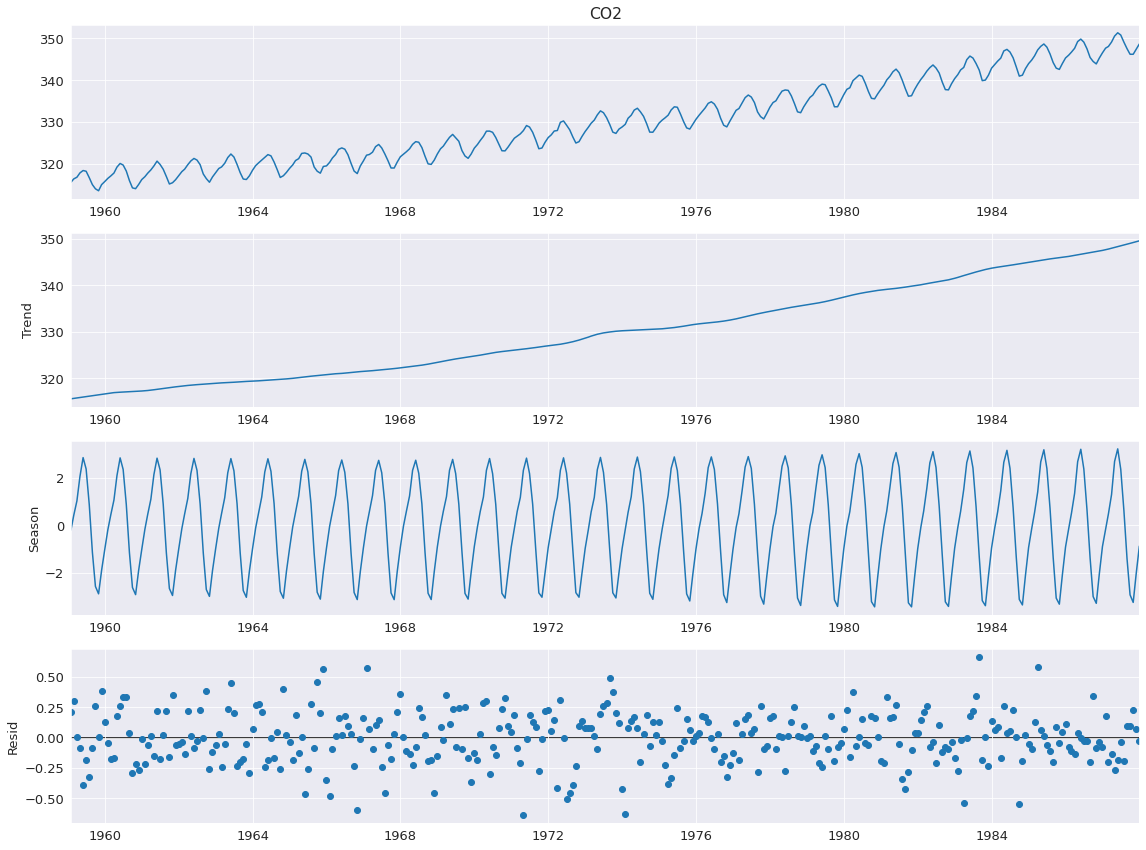

In [4]:
from statsmodels.tsa.seasonal import STL
stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()

## Robust Fitting
Setting `robust` uses a data-dependent weighting function that re-weights data when estimating the LOESS (and so is using LOWESS). Using robust estimation allows the model to tolerate larger errors that are visible on the bottom plot.

Here we use a series the measures the production of electrical equipment in the EU.

In [5]:
from statsmodels.datasets import elec_equip as ds
elec_equip = ds.load(as_pandas=True).data

Next, we estimate the model with and without robust weighting.  The difference is minor and is most pronounced during the financial crisis of 2008. The non-robust estimate places equal weights on all observations and so produces smaller errors, on average.  The weights vary between 0 and 1.

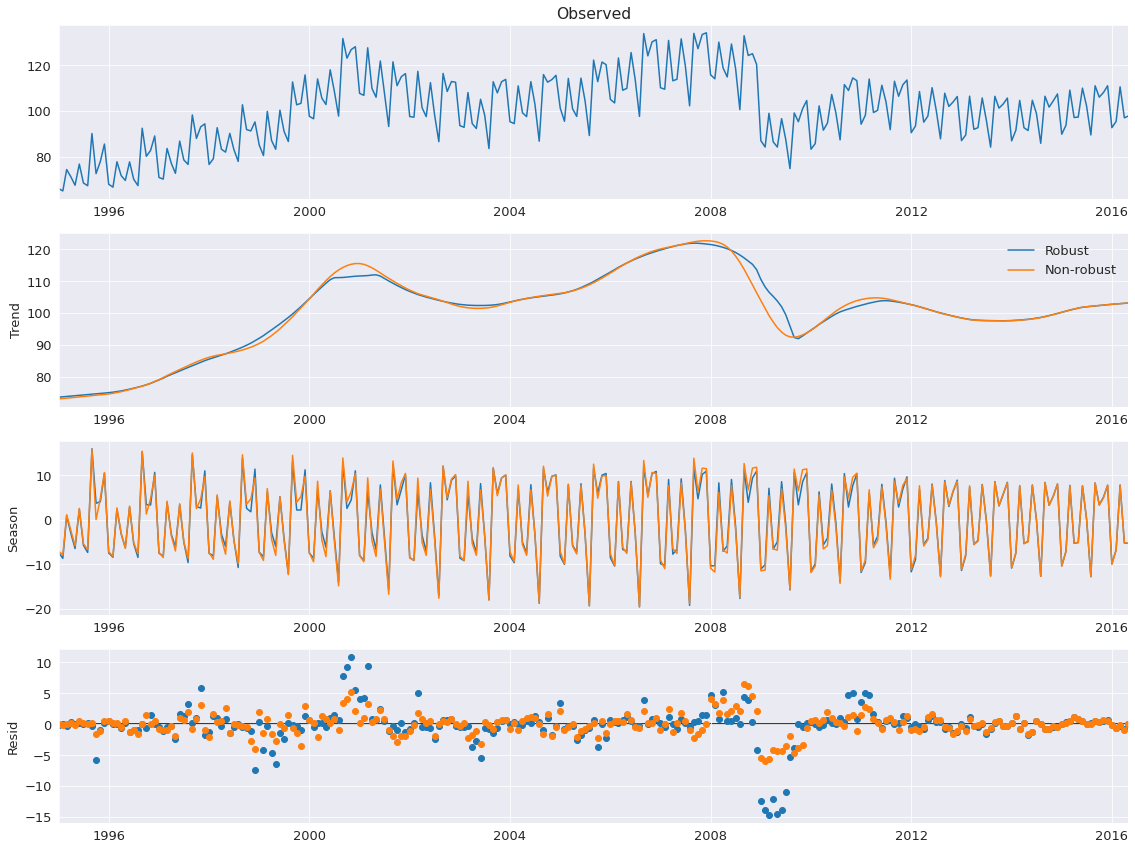

In [6]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)    
                

stl = STL(elec_equip, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(elec_equip, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

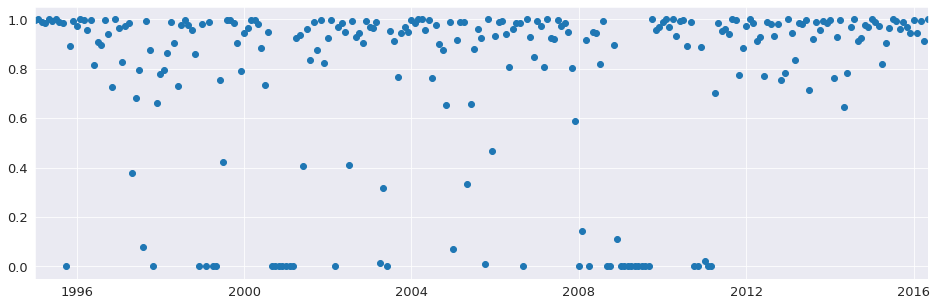

In [7]:
fig = plt.figure(figsize=(16,5))
lines = plt.plot(res_robust.weights, marker='o', linestyle='none')
ax = plt.gca()
xlim = ax.set_xlim(elec_equip.index[0], elec_equip.index[-1])

## LOESS degree
The default configuration estimates the LOESS model with both a constant and a trend.  This can be changed to only include a constant by setting `COMPONENT_deg` to 0. Here the degree makes little difference except in the trend around the financial crisis of 2008.

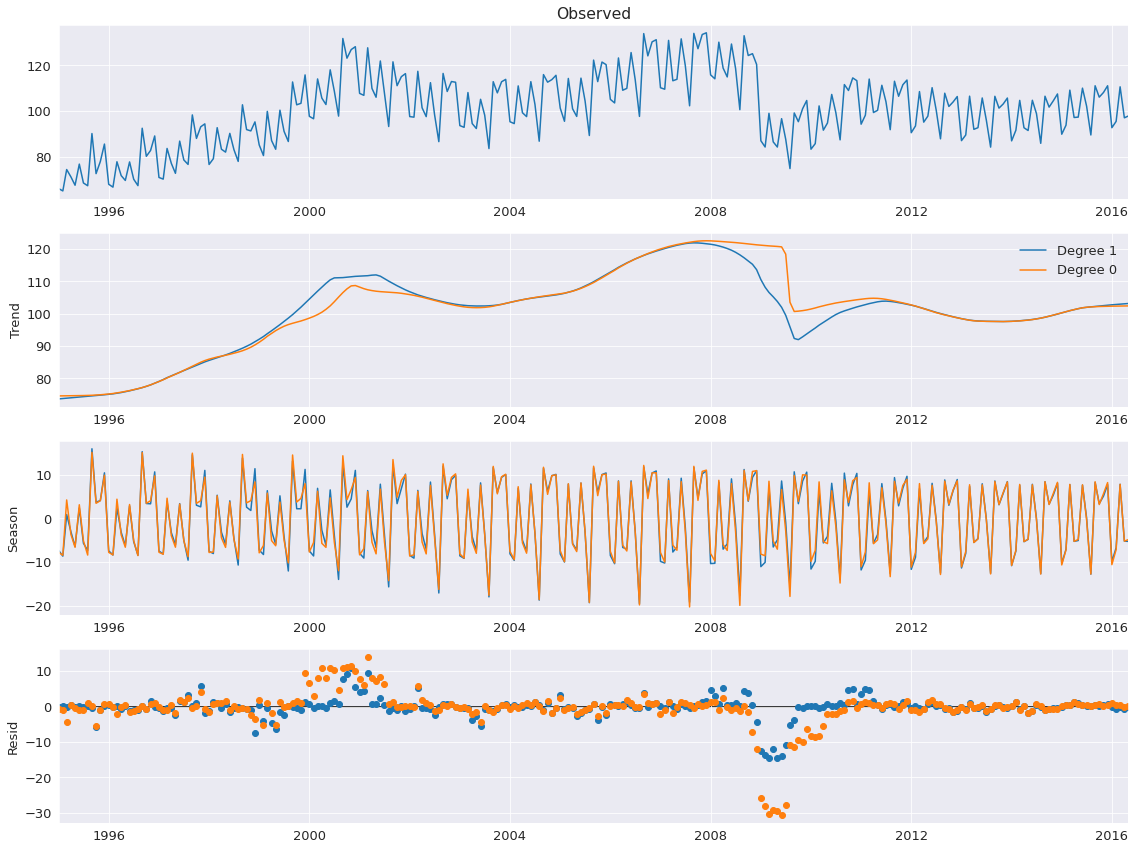

In [8]:
stl = STL(elec_equip, period=12, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True)
res_deg_0 = stl.fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ['Degree 1','Degree 0'])

## Performance
Three options can be used to reduce the computational cost of the STL decomposition:

* `seasonal_jump`
* `trend_jump`
* `low_pass_jump`

When these are non-zero, the LOESS for component `COMPONENT` is only estimated ever `COMPONENT_jump` observations, and linear interpolation is used between points. These values should not normally be more than 10-20% of the size of `seasonal`, `trend` or `low_pass`, respectively. 

The example below shows how these can reduce the computational cost by a factor of 15 using simulated data with both a low-frequency cosinusoidal trend and a sinusoidal seasonal pattern.

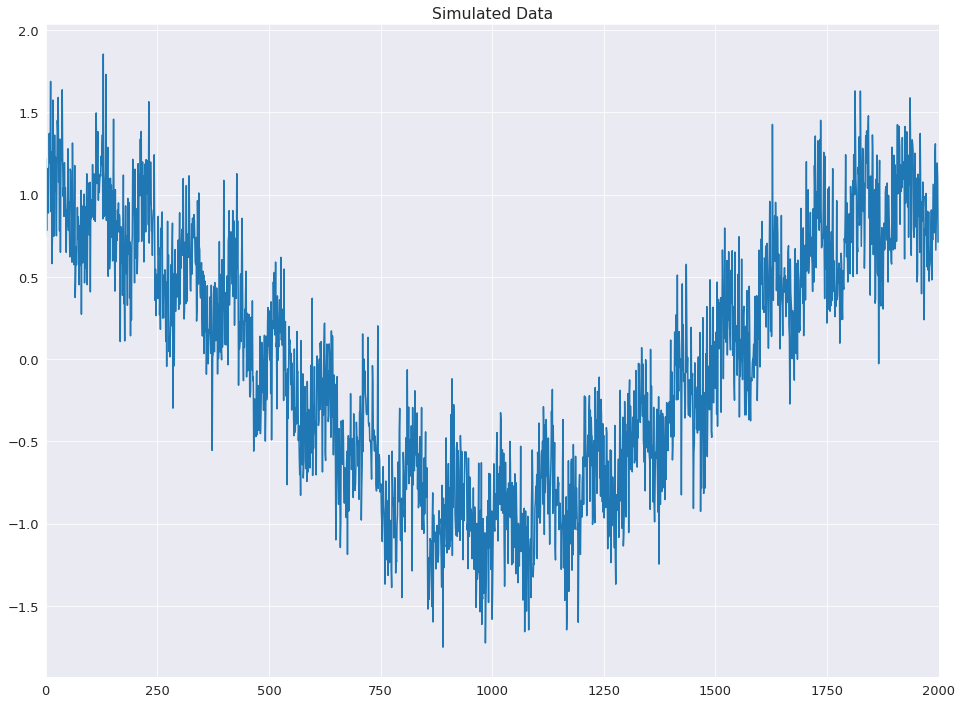

In [9]:
import numpy as np
rs = np.random.RandomState(0xA4FD94BC)
tau = 2000
t = np.arange(tau)
period = int(0.05 * tau)
seasonal = period + ((period % 2) == 0)  # Ensure odd
e = .25*rs.standard_normal(tau)
y = np.cos(t / tau * 2 * np.pi) + 0.25 * np.sin(t / period * 2 * np.pi) + e
plt.plot(y)
plt.title('Simulated Data')
xlim = plt.gca().set_xlim(0, tau)

First, the base line model is estimated with all jumps equal to 1. 

1.63 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


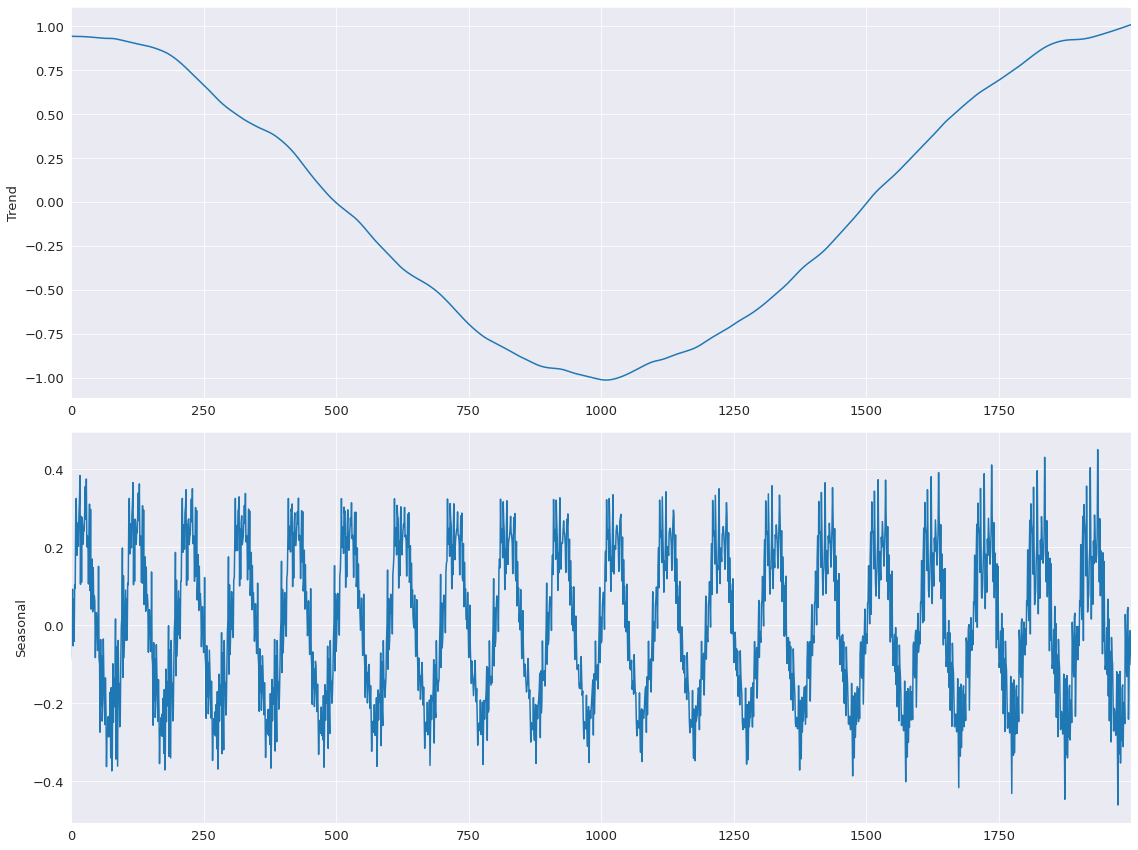

In [10]:
mod = STL(y, period=period, seasonal=seasonal)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)

The jumps are all set to 15% of their window length. Limited linear interpolation makes little difference to the fit of the model.

110 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


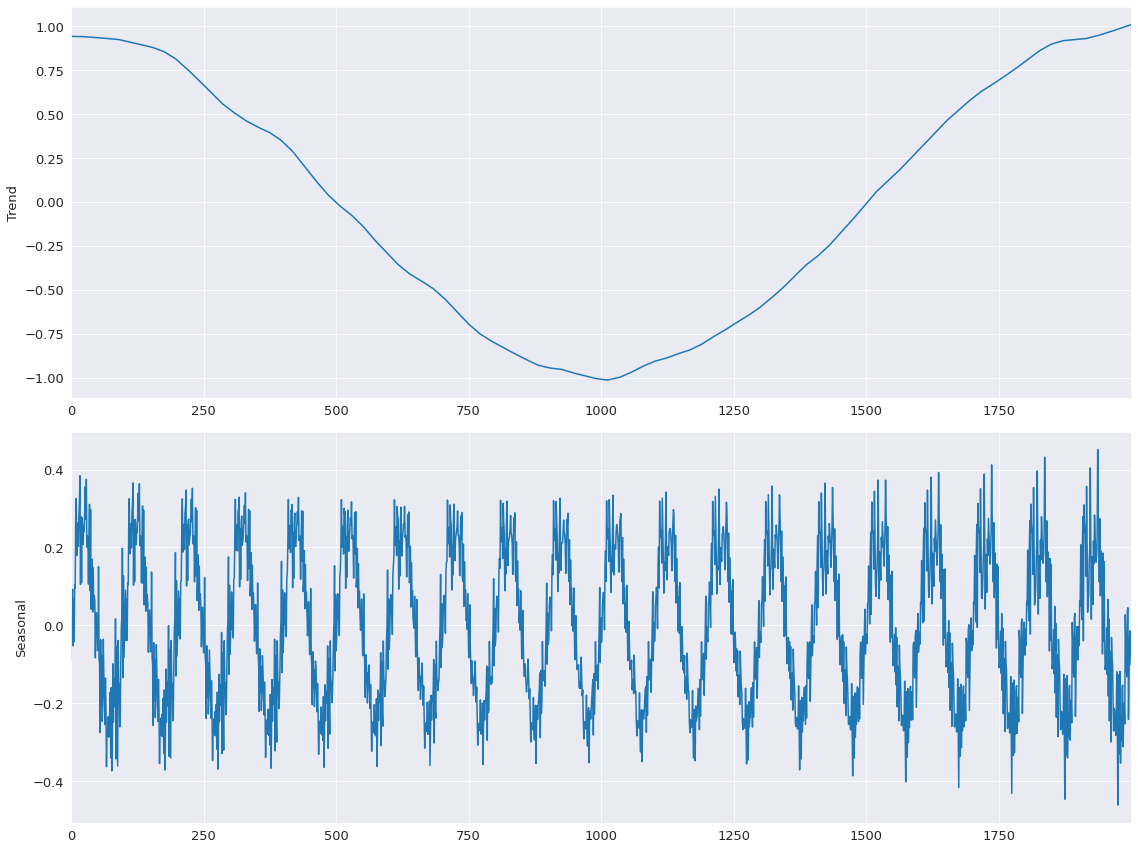

In [11]:
low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
trend_jump = int(0.15 * 1.5 * (period + 1))
mod = STL(y, period=period, seasonal=seasonal, seasonal_jump=seasonal_jump, 
          trend_jump=trend_jump, low_pass_jump=low_pass_jump)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)

## Forecasting with STL

``STLForecast`` simplifies the process of using STL to remove seasonalities and then using a standard time-series model to forecast the trend and cyclical components. 

Here we use STL to handle the seasonality and then an ARIMA(1,1,0) to model the deseasonalized data. The seasonal component is forecast from the find full cycle where 

$$E[S_{T+h}|\mathcal{F}_T]=\hat{S}_{T-k}$$

where $k= m - h + m \lfloor \frac{h-1}{m} \rfloor$. The forecast automatically adds the seasonal component forecast to the ARIMA forecast.

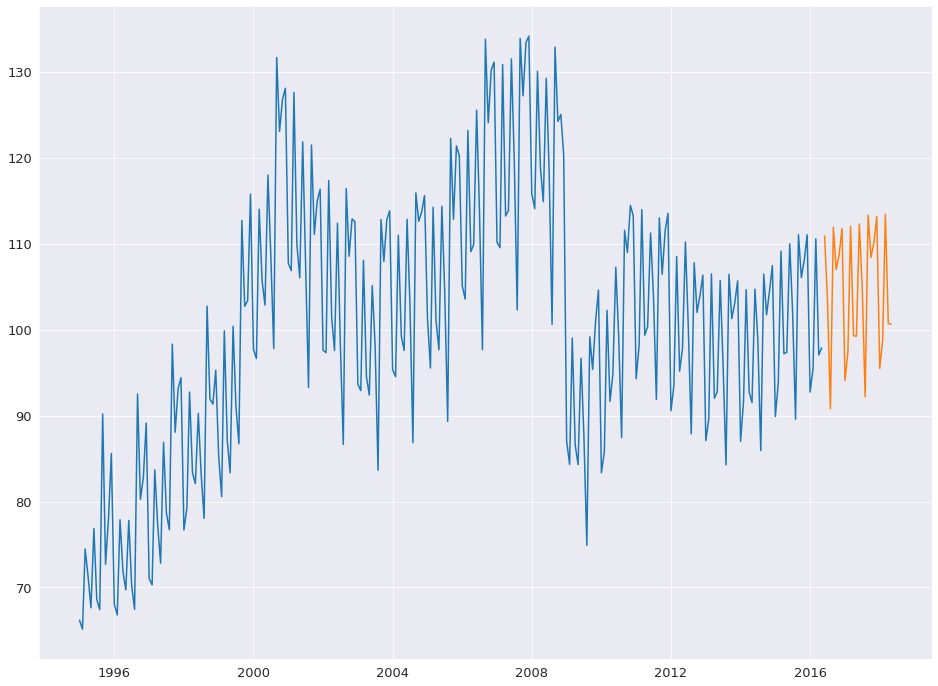

In [12]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

elec_equip.index.freq = elec_equip.index.inferred_freq
stlf = STLForecast(elec_equip, ARIMA, model_kwargs=dict(order=(1,1,0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)
plt.plot(elec_equip)
plt.plot(forecast)
plt.show()

``summary`` contains information about both the time-series model and the STL decomposition.

In [13]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  257
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -522.434
Date:                Tue, 02 Feb 2021   AIC                           1050.868
Time:                        07:03:43   BIC                           1061.504
Sample:                    01-01-1995   HQIC                          1055.146
                         - 05-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1171      0.118      0.995      0.320      -0.113       0.348
ar.L1         -0.0435      0.049     -0.880      0.379      -0.140       0.053
sigma2         3.4682      0.188     18.406      0.0